# Data loading

In [1]:
#  to present any diagrams inline with the rest of the notebook as opposed to in new browser window
%matplotlib inline 

# importing necessary modules
import pandas as pd
import seaborn as snb


path_to_csv = "data/abalone.csv"

### Specifying data indices
In order to easily identify data, which in the dataset provided doesn't have headers specified, we need to name our columns. 
At the same time we can add indices to the columns to speed up computations and enable random access to data.

In [2]:
df = pd.read_csv(path_to_csv, names=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight','viscera_weight', 'shell_weight','rings'], header=None)

We need to verify that the data was imported successfully. The easiest avenue is to check the head and tail of the dataset

In [3]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
df.tail()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


# Data cleaning
## Checking for empty records
The very first thing that needs to be performed on any dataset, before any analysis can be perfoermed is cleaning the data. The rationale behind it is that missing records can and will skew any computations done on the dataset. We can use `isnull` method inherent to any `Data Frame`.

In [5]:
nan_error = df.isnull().any(axis=1)
df[nan_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
878,F,0.635,0.485,0.165,1.2945,0.6680,NaN,0.2715,9
1888,F,0.565,0.445,0.125,0.8305,0.3135,0.1785,0.2300,NaN
3093,NaN,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.2350,11


From the data above we can see that some records are missing data:
 - Row 878 is missing `viscera weight` property
 - Row 1888 is missing `rings` value
 - Row 3093 doesn't have value for `sex` specified

## Checking dataset for errorenous data
Before re remove any data we shoul analyze if there are any errors in the dataset. It should e done before removal of any data as if the number or errors in data is significant in may become necessary to substitute wrong data and at the same time it may be possible to fill the data gaps as well.
### Values below or equal to 0
For abalone, as a living organism, it doesn't make sense for any of its attributes to be below or equal to zero.

In [6]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4176.000000,4177.000000
mean,0.523992,0.407675,0.139516,0.828742,0.359367,0.180574,0.238831
std,0.120093,0.100082,0.041827,0.490389,0.221963,0.109620,0.139203
min,0.075000,-0.430000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093375,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.170750,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.252625,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [7]:
below_or_zero=df[df <= 0.0 ].count()
below_or_zero

sex               4176
length               0
diameter             1
height               2
whole_weight         0
shucked_weight       0
viscera_weight       0
shell_weight         0
rings             4176
dtype: int64

We're not concerned with `sex` column being reported as it's not a numeric data. For the rings data we need to check it with `integer` type applied instead of a floating point one.

From the description and computation we see that there are a min of 0 for height and a negative value for diameter which in case of a living organism like abalone isn't valid. We need to track down which row exactly contain error data and remove them.

In [8]:
error_diameter=df['diameter'] <= 0.0
error_height = df['height'] <= 0.0
df[error_diameter]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
2758,M,0.535,-0.43,0.155,0.7845,0.3285,0.169,0.245,10


In [9]:
df[error_height]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


Now that we know that there are negative values in the dataset we need to locate and remove them.

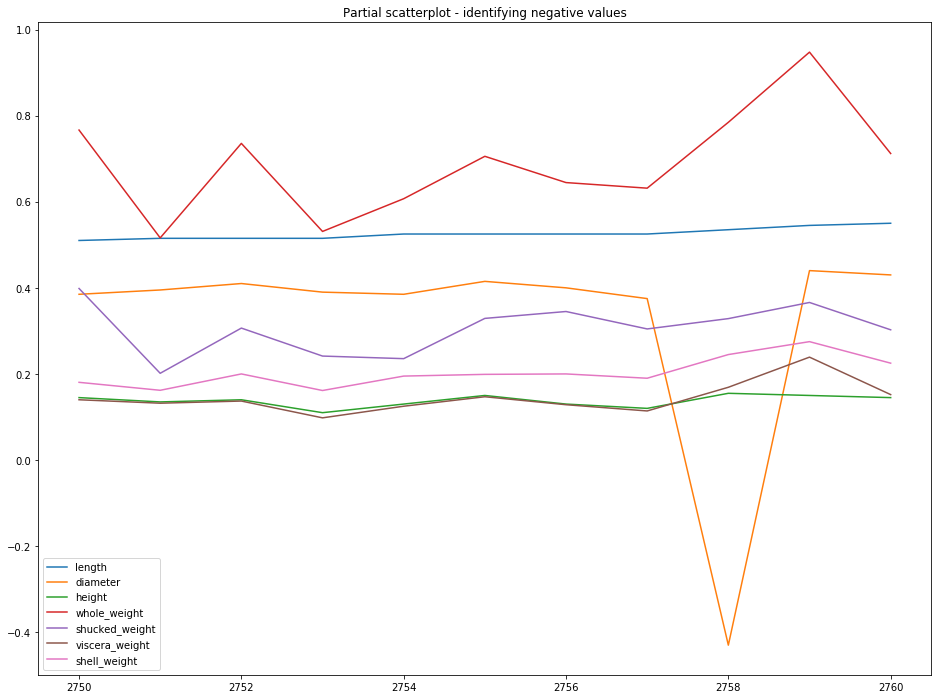

In [10]:
# tuning graph to look for negative diameter. Start at full dataset and then manipulate location param to narrow down focus
df.loc[2750:2760].plot(figsize=(16,12), title='Partial scatterplot - identifying negative values')

## Analyzing data for domain errors
Endemic to abalone itself it is invalid for any specimen to have:
 - higher weight when shucked (stripped of its shell) than whole weight
 - higher viscera weight than whole weight
 - higher shell weight than whole weight

We can do 2 things to find the errors:
 - computation method
 - scatter matrix dedicated to specific parameters listed above

While it is possible to identify errors using visual method by narrowing down the graph field to precise location of the errorneous data it is much faster to compute it.

In [11]:
shucked_error =df['shucked_weight'] > df['whole_weight']
df[shucked_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1216,I,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5
2641,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7
3086,I,0.355,0.270,0.075,0.2040,0.3045,0.0460,0.0595,7


In [12]:
df[df['viscera_weight'] > df['whole_weight']]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [13]:
shell_error = df['shell_weight'] > df['whole_weight']
df[shell_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


## Summary of errorenous data
We have 3 rows with non-numerical values:
 - 878
 - 1888
 - 3093
 
7 rows with data that cannot be correct for domain reasons:
 - 4 where shucked weight is higher than whole weight
   - 1216
   - 2627
   - 2641
   - 3086
 - 1 row with negative value for diameter
   - 2758
 - 2 rows with 0 value for height
   - 1257
   - 3996

Row 3996 has been flagged by 2 checks as one containing impossible values: height and shell weight higher than whole weight, however, is only contributes towards row-error count once.
 
In summary we have 10 rows that either have to have some of the values substituted or removed.

From checking the tail of the dataset in previous section we know that the dataset contains 4176 rows. 

As such 10 rows with missing data comprises less than 0.24% of the dataset and removing such a small amount or errorenous data should not affect our analysis significantly. 
Had the number been more significant the missing data would have had to been substituted.

# Removing error data

In [14]:
# deleting shucked weight > whole weight
df.drop(df.index[(shucked_error) | (error_diameter) | (error_height) | (nan_error)], inplace=True)

#verifying shucked > whole that records were dropped
df[df['shucked_weight'] > df['whole_weight']]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [15]:
# verifying NaN errors were deleted
df[df.isnull().any(axis=1)]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [16]:
#verifying diameter < 0 records were dropped
df[df['diameter'] <= 0.0]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [17]:
# verifying height <= 0 was dropped
df[df['height'] <= 0.0]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


# Indentifying outliers and correlation
## Scatter matrices

In [18]:
# pd.plotting.scatter_matrix(df, figsize=(12,16), s=100)